In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import plotly.express as px
import scipy as sp
import seaborn as sns
import shap as sh
import sklearn as sk

f:\DATA Scientist\VSCODE_DataScience_JyTRAN\Metasnake_Pandas_Practice_Nov2024\venv_exos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory Data Analysis

## Datasets

In [3]:
# importing the .csv dataset with pyarrow engine
csv_path = r"F:\DATA Scientist\VSCODE_DataScience_JyTRAN\Metasnake_Pandas_Practice_Nov2024\data\raw\mask-use-by-county.csv"

df = pd.read_csv(csv_path, engine="pyarrow", dtype_backend="pyarrow")

### Converting to pyarrow data types

For a faster experience throughout this notebook and as a preprocessing requirement for most Data projects, we convert all the Series of `df` into lighter data types that are processed by pandas 2 (pyarrow), if it is relevant.

For example, for `COUNTYFP`, we will convert it to int32, which is lighter than int64 and more relevant as its max value is quite high (see below) but too high for an int16 type. .

In [4]:
df.COUNTYFP.max()

56045

In [5]:
df.columns

Index(['COUNTYFP', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], dtype='object')

After examining each column data type and its max value if it is a numerical data, we ended up selecting these following data types:

In [6]:
df = df.astype({
    'COUNTYFP': 'int32[pyarrow]',
    'NEVER': "float32[pyarrow]",
    'RARELY': "float32[pyarrow]",
    'SOMETIMES': "float32[pyarrow]",
    'FREQUENTLY': "float32[pyarrow]",
    'ALWAYS': "float32[pyarrow]",
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   COUNTYFP    3142 non-null   int32[pyarrow]
 1   NEVER       3142 non-null   float[pyarrow]
 2   RARELY      3142 non-null   float[pyarrow]
 3   SOMETIMES   3142 non-null   float[pyarrow]
 4   FREQUENTLY  3142 non-null   float[pyarrow]
 5   ALWAYS      3142 non-null   float[pyarrow]
dtypes: float[pyarrow](5), int32[pyarrow](1)
memory usage: 76.1 KB


You could argue that the numpy float16 type uses 2 bytes per float against 4 with pyarrow's float32 (no float16 available) but we want to keep a high consistency level in engine use, mostly pyarrow.  
Indeed, later on we will also convert a heavy dataframe with numerous strings per columns, and the 'category' data type from pyarrow is well optimized for our use case here (for the column of all the list of thousands of counties, almost all unique). 

## County columns made of INT only

The column of the County where each county is **listed as a FIPS code**, not by its name, is too vague because most people do not know Counties by their FIPS code. So we need to know:
- what are **their names** 
- and also to **what state they belong to**. 

We are **isolating that column in a var** in the next cell so that we **can cross check it** with the dataset holding the names and corresponding states.

In [7]:
# Series of all the county FIPS code:
county_fips_ser = df.COUNTYFP

## Adding State and County Columns

As mentioned above, our initial dataset "mask-use-by-county.csv" is not showing county names nor their corresponding state. This is why another dataset comes in to add those.

In [8]:
# importing the csv file of the county list of 2020
cties_path = r"F:\DATA Scientist\VSCODE_DataScience_JyTRAN\Metasnake_Pandas_Practice_Nov2024\data\raw\us-counties-2020.csv"

df_cties = pd.read_csv(cties_path, 
                       engine="pyarrow", 
                       dtype_backend="pyarrow")

Note again that we made sure to use the pyarrow engine and data type backend. 

### Converting to CATEGORY

As mentioned previously, we should convert the string Series to be of the **category data type** (dtype). 

In [9]:
df_cties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884737 entries, 0 to 884736
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype               
---  ------  --------------   -----               
 0   date    884737 non-null  date32[day][pyarrow]
 1   county  884737 non-null  string[pyarrow]     
 2   state   884737 non-null  string[pyarrow]     
 3   fips    876471 non-null  int64[pyarrow]      
 4   cases   884737 non-null  int64[pyarrow]      
 5   deaths  865976 non-null  int64[pyarrow]      
dtypes: date32[day][pyarrow](1), int64[pyarrow](3), string[pyarrow](2)
memory usage: 43.5 MB


The two columns that we need, **'county' and 'state' are of the dtype string**, so we will now convert them. We will not need the columns 'cases' and 'deaths', nor the 'date' one but we'll keep it anyway. 

In [10]:
date_parrow = 'timestamp[ns][pyarrow]'

df_cties = df_cties.astype({
    'date': date_parrow,
    'county': 'category',
    'state': 'category',
    'fips': 'int32[pyarrow]'
})
df_cties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884737 entries, 0 to 884736
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype                 
---  ------  --------------   -----                 
 0   date    884737 non-null  timestamp[ns][pyarrow]
 1   county  884737 non-null  category              
 2   state   884737 non-null  category              
 3   fips    876471 non-null  int32[pyarrow]        
 4   cases   884737 non-null  int64[pyarrow]        
 5   deaths  865976 non-null  int64[pyarrow]        
dtypes: category(2), int32[pyarrow](1), int64[pyarrow](2), timestamp[ns][pyarrow](1)
memory usage: 26.5 MB


Note that we saved 17MB of memory use, **about 40% of the original 43.5MB**.

### Adding the new columns and populating them

In [11]:
# Step 1: copy of df
df_mapped = df.copy()

# Step 2: .merge() the columns
merged_df = df_mapped.merge(df_cties, left_on="COUNTYFP", right_on="fips", how="left")

# Step 3: add the values of col County and State
df_mapped["COUNTY"] = merged_df["county"]
df_mapped["STATE"] = merged_df["state"]

# Step 4: Reorder columns to place COUNTY and STATE after COUNTYFP
column_order = ["COUNTYFP", "COUNTY", "STATE"] + [
    col for col in df_mapped.columns if col not in ["COUNTYFP", "COUNTY", "STATE"]
]
df_mapped = df_mapped[column_order]

df_mapped.head()

,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,Autauga,Alabama,0.053,0.074,0.134,0.295,0.444
1,1003,Autauga,Alabama,0.083,0.059,0.098,0.323,0.436
2,1005,Autauga,Alabama,0.067,0.121,0.12,0.201,0.491
3,1007,Autauga,Alabama,0.02,0.034,0.096,0.278,0.572
4,1009,Autauga,Alabama,0.053,0.114,0.18,0.194,0.459


So far we just added the columns COUNTY and STATE. 
Let's populate them thanks to their matching FIPS code from the original COUNTYFP column. 

In [12]:
# Step 5: Loop through each value in COUNTYFP and check for matches
for index, row in df_mapped.iterrows():
    countyfp_value = row["COUNTYFP"]

    # Check if the value exists in the fips column of df_cties
    match = df_cties[df_cties["fips"] == countyfp_value]

    if not match.empty:
        # If there's a match, assign the corresponding values
        df_mapped.at[index, "COUNTY"] = match["county"].values[0]
        df_mapped.at[index, "STATE"] = match["state"].values[0]
        
df_mapped.head()

,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,Autauga,Alabama,0.053,0.074,0.134,0.295,0.444
1,1003,Baldwin,Alabama,0.083,0.059,0.098,0.323,0.436
2,1005,Barbour,Alabama,0.067,0.121,0.12,0.201,0.491
3,1007,Bibb,Alabama,0.02,0.034,0.096,0.278,0.572
4,1009,Blount,Alabama,0.053,0.114,0.18,0.194,0.459


**NOTE :**  

We saved a whole **16 seconds** of computing time. Without the conversion of the df_cities dataframe we performed earlier this would have taken 43 sec. (on the local PC used here) instead of the 28 sec. that we waited.  
We will save time down the line too, when plotting graphs will be needed. 

We now have the main dataframe df added with the COUNTY names and the STATE names it belongs to. 

## Counts of Counties per State

Because the main df is giving us one set of answers in the form of shares (percentages on a scale of 1), and that there is one set per county, it is useful for us to know/visualize how the counties are distributed among all States.  

We will see each state as a bar. But before that, we should look at the boxplot of all these states.

<Axes: >

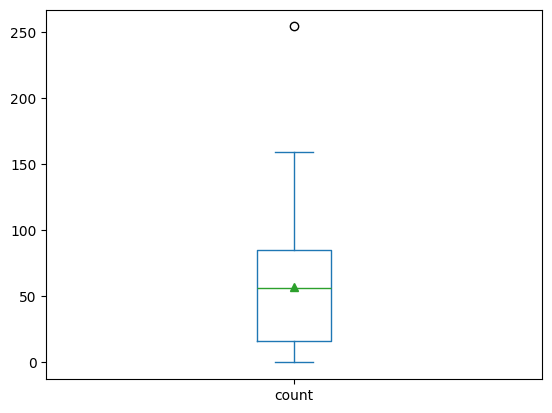

In [13]:
# Series of all States
states_ser = df_mapped.STATE

# Count of Counties of each state
state_counts = states_ser.value_counts()

# converting to int16 dtype
state_counts = state_counts.astype('int16[pyarrow]')
state_counts.plot.box(showmeans=True)

The first half of all the counties involved in the survey lies within the range of 0 to about 55. This means that half of all the states are each listing 55 or less counties each.  
The other half is more spread out, the range here being ~55 to ~160. 

The outlier is Texas with 254 counties. 

In [14]:
state_counts.dtypes
state_counts.head()

STATE
Texas       254
Georgia     159
Virginia    133
Kentucky    120
Missouri    115
Name: count, dtype: int16[pyarrow]

There is a total of 48 states in our df.

In [15]:
# Number of uniques States
state_counts.nunique()

48

### Horizontal Bars plot

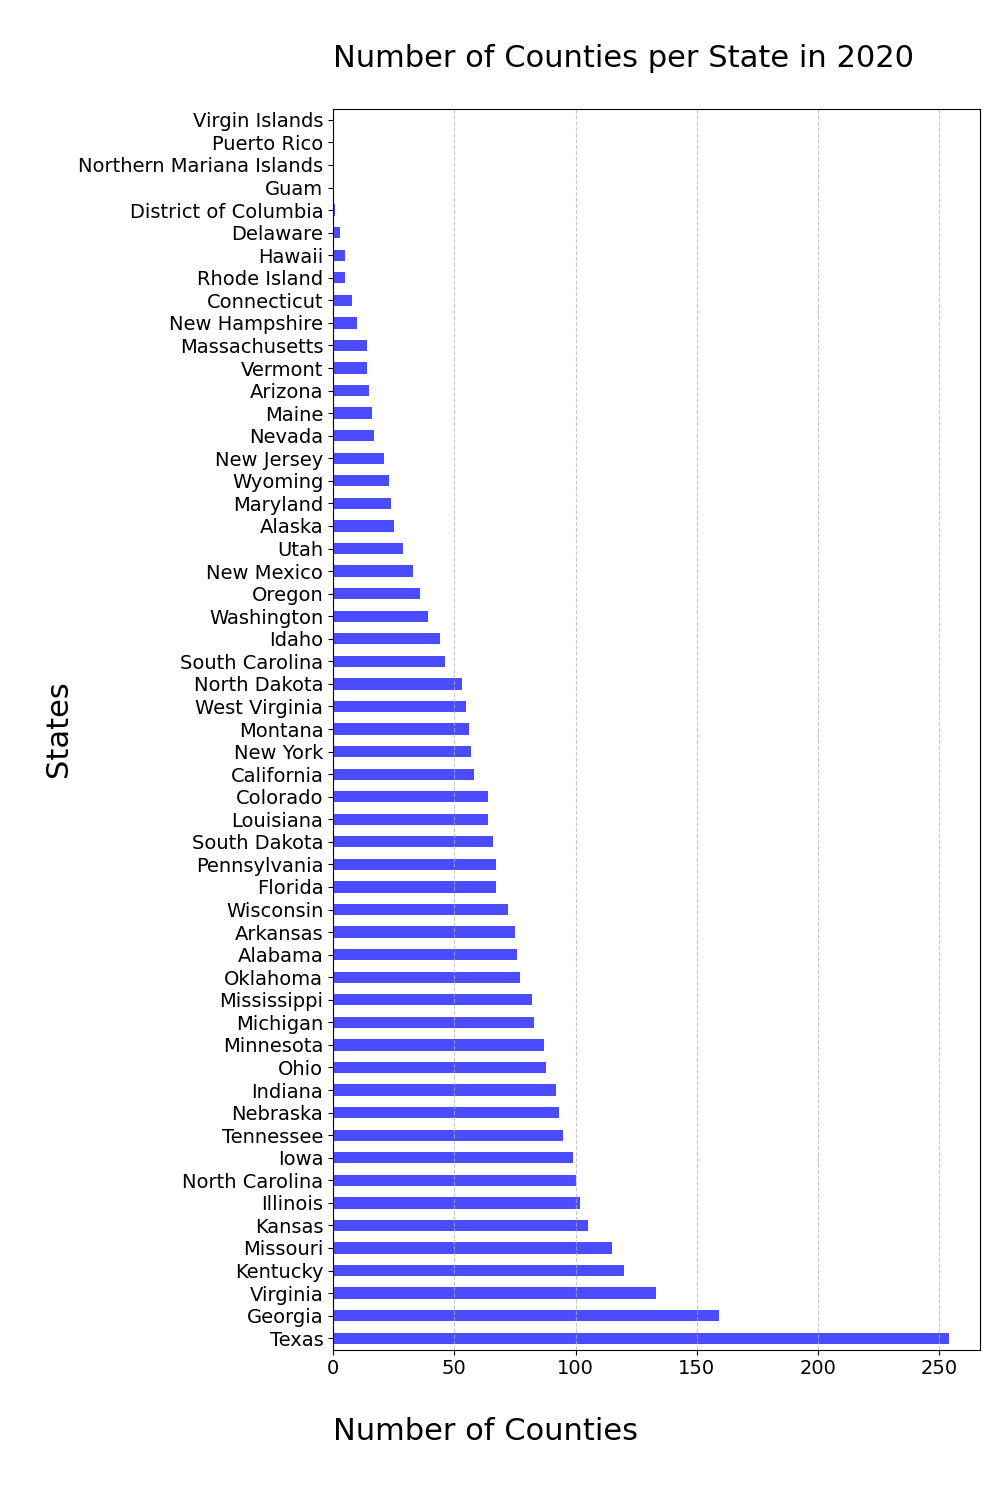

In [16]:
# Create a bar plot
ax = state_counts.plot(
    kind="barh", color="blue", alpha=0.7, fontsize=14, figsize=(10, 15)
)

# Set labels and title with specific font sizes
ax.set_ylabel("\nStates", fontsize=22)  # Change font size for x-label
ax.set_xlabel("\nNumber of Counties\n", fontsize=22, loc="left")  # Change font size for y-label
ax.set_title(
    "\nNumber of Counties per State in 2020\n", fontsize=22, loc="left"
)  # Change font size for title

# Add vertical grid lines
ax.xaxis.grid(True, linestyle="--", alpha=0.7)  # Vertical grid lines

# Show the plot
plt.tight_layout()  # Adjust layout to make room for rotated x-ticks
plt.show()

## Top 5 States with the Most Counties

The bar graph above showed us that 5 states are noticeably well above all the others in terms of number of counties: 
- Texas (outlier with 254 counties)
- Georgia
- Virginia
- Kentucky
- Missouri

How much is their total combined?

In [17]:
print(f"\nThe total of the top 5 states is:\n\t{state_counts.head(5).sum()} counties\nThe total of all states' counties is\n\t{state_counts.sum()} counties\n")


The total of the top 5 states is:
	781 counties
The total of all states' counties is
	3142 counties



In [18]:
divided = state_counts.head(5).sum() / state_counts.sum()

print(f"\nThe percentage of top 5 states is:\n\t{round(divided *100, 2)}%\n")


The percentage of top 5 states is:
	24.86%



Let's round this to 25%. Now we can say that within these 5 states alone we have in average 1 answer out of 4.  
The proportion is significant for such a small number of States.  

Texas alone is holding a third of these 25% (about 9% of the total). 
So, we should have a look at each of them, through a box plot.

### Box Plot of the Top 5

In [19]:
top5 = state_counts.head(5).index.tolist()
top5

['Texas', 'Georgia', 'Virginia', 'Kentucky', 'Missouri']

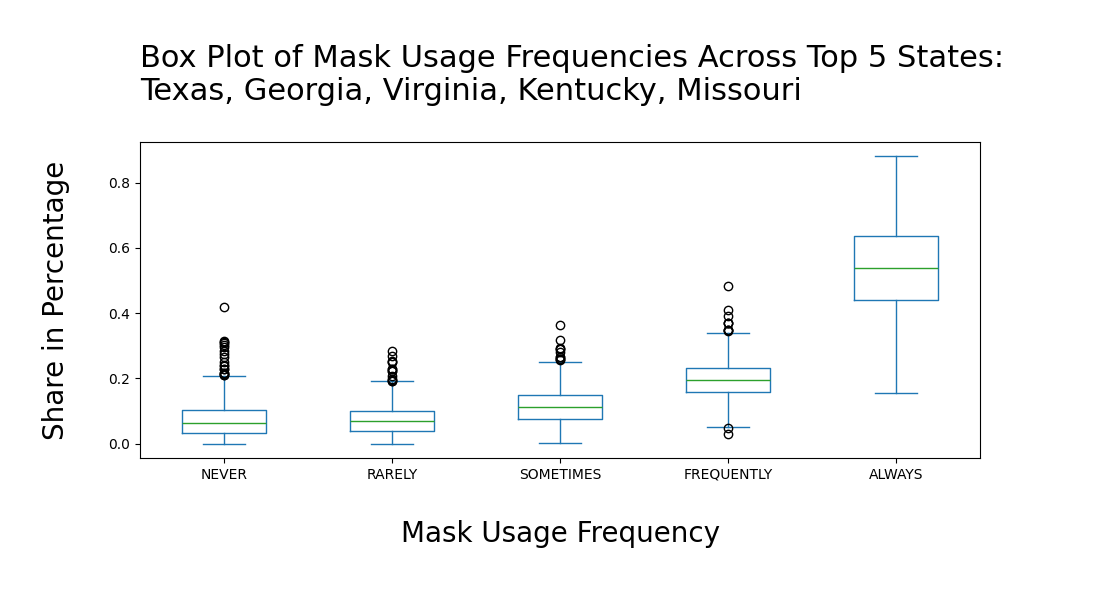

In [20]:
# Filter the DataFrame for the selected states
df_top5 = df_mapped[df_mapped["STATE"].isin(top5)]

# Plot a single box plot for each mask usage frequency column
df_top5[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]].plot(
    kind="box", figsize=(10, 6)
)

# Customize plot
plt.title("\nBox Plot of Mask Usage Frequencies Across Top 5 States:         \nTexas, Georgia, Virginia, Kentucky, Missouri\n", fontsize=22, loc="left")
plt.xlabel("\nMask Usage Frequency\n", fontsize=20)
plt.ylabel("\nShare in Percentage\n", fontsize=20)
plt.tight_layout()

The **median line** for all the four first frequencies is **under 0.2**.  
This means that within these 5 states, each of these 4 frequencies is made of under 20% of people.  For FREQUENTLY, the share is about 20%.  

This leaves the **ALWAYS** frequency a **big chunk of the cake**, showing that **most people behave well and always wear their mask**.  

We see the outliers. They will **come back to us later**. 

## 0 or 1 county States
From the horizontal bars plot we showed earlier,  we noticed that the 5 states on top of it each has 0 or 1 county. Let's investigate that info further. 

In [21]:
state_counts.tail(5)

STATE
District of Columbia        1
Guam                        0
Northern Mariana Islands    0
Puerto Rico                 0
Virgin Islands              0
Name: count, dtype: int16[pyarrow]

In [22]:
# Fetching the 5 states with 0 or 1 county
five_states= state_counts.tail(5).index.tolist()
five_states

['District of Columbia',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Virgin Islands']

We now try to see the data for these 0 to 1 county states. 

In [23]:
df_5states = df_mapped[df_mapped['STATE'].isin(five_states)]
df_5states

,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
319,11001,District of Columbia,District of Columbia,0.012,0.013,0.069,0.164,0.743


Only the District of Columbia is returned because it has 1 county and therefore it has data to show.  
Hence, the 4 others do not hold any data entries. Let's remove them from `df_mapped`. 

In [24]:
# Fetching the 4 states in one list
four_states_toremove = state_counts.tail(4).index.tolist()

# removing them from df_mapped:
df_mapped = df_mapped[~df_mapped.STATE.isin(four_states_toremove)]

print(df_mapped[df_mapped['STATE'].isin(four_states_toremove)])

Empty DataFrame
Columns: [COUNTYFP, COUNTY, STATE, NEVER, RARELY, SOMETIMES, FREQUENTLY, ALWAYS]
Index: []


The data of the District of Colombia is very similar to what the box plot showed for the top 5 states. Nothing unusual here, apparently. 

## Top 20 states with the most counties

After we looked at the top 5 states, we should take a higher view and look at more states.

<Axes: title={'center': 'Top 20 States with the most Counties (48 states in total)'}, xlabel='Percentage of all Counties', ylabel='STATE'>

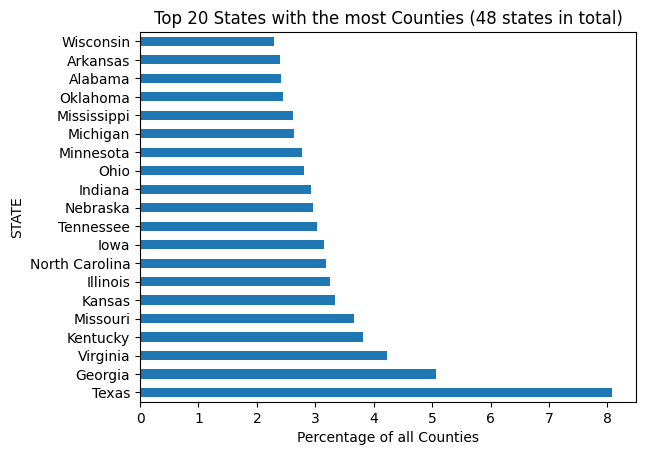

In [25]:
((state_counts / state_counts.sum()) * 100).head(20).plot.barh(
    xlabel='Percentage of all Counties',
    title='Top 20 States with the most Counties (48 states in total)'
)


In [26]:
print(f"\nThe total percentage of the top 20 States with the most counties is:\n\t{round(((state_counts / state_counts.sum()) * 100).head(20).sum(), 2)} %\n")
print(f"The total percentage of the top 30 States with the most counties is:\n\t{round(((state_counts / state_counts.sum()) * 100).head(30).sum(), 2)} %\n")
print(f"The total percentage of the top 40 States with the most counties is:\n\t{round(((state_counts / state_counts.sum()) * 100).head(40).sum(), 2)} %\n")


The total percentage of the top 20 States with the most counties is:
	67.06 %

The total percentage of the top 30 States with the most counties is:
	86.38 %

The total percentage of the top 40 States with the most counties is:
	96.56 %



In other words: 
- 20 states is **42%** of all states **holding 67% of all counties**
- 30 states is **63%** of all states holding **86%** of all counties
- 40 is **83%** of all states holding almost **100%** of all counties

The **concentration of counties** we have seen with the top 5 states is, to a lesser extent, **also observed** when we look at more states. 

## Mean of the Frequency columns

I am interested in knowing the **mean of the frequency columns**, that is 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS' **from all States and counties**, not just the top 5. 

In [27]:
df_mapped.columns

Index(['COUNTYFP', 'COUNTY', 'STATE', 'NEVER', 'RARELY', 'SOMETIMES',
       'FREQUENTLY', 'ALWAYS'],
      dtype='object')

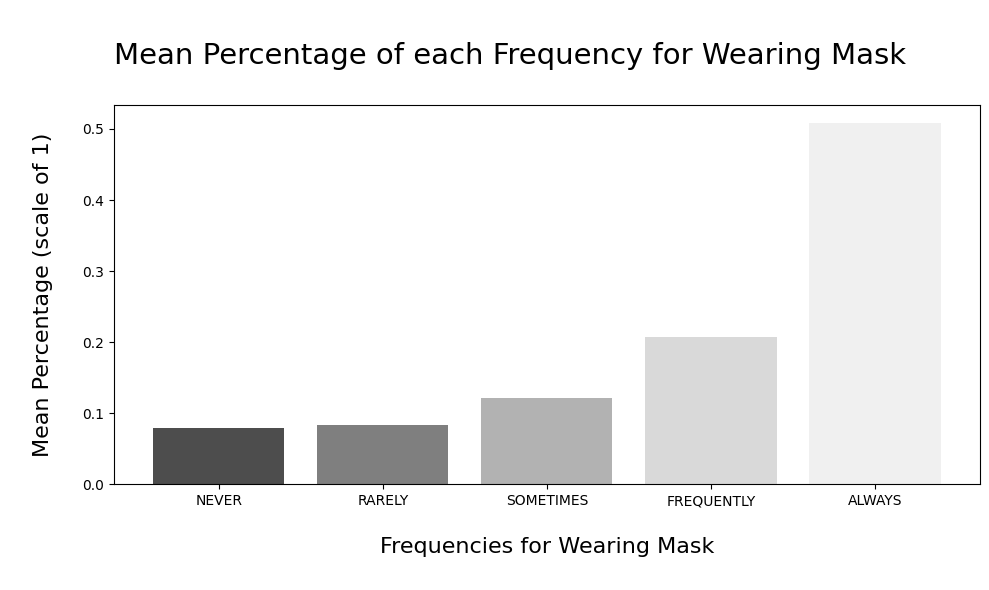

In [28]:
# Calculate the mean of each column
mean_values = df_mapped[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]].mean()

# Define grayscale colors from darkest to lightest
colors = ["#4D4D4D", "#7F7F7F", "#B2B2B2", "#D9D9D9", "#F0F0F0"]

# Plot the means as a single stacked bar
plt.figure(figsize=(10, 6))
plt.bar(mean_values.index, mean_values, color=colors)

# Customize the plot
plt.xlabel("\nFrequencies for Wearing Mask\n", fontsize=16)
plt.ylabel("\nMean Percentage (scale of 1)\n", fontsize=16)
plt.title("\nMean Percentage of each Frequency for Wearing Mask\n", fontsize=21, loc="left")
plt.xticks(rotation=0)  # Adjust rotation for better readability
plt.tight_layout()

plt.show()

Clearly it appears that we have the **same indications** we had from the top 5 box plot.   

Maybe, what we also see is that **NEVER, RARELY and SOMETIMES**, if put together, total ~3.3, which is **about 33% in average**.  
Let's explore these 3 columns and **see if there is any State or County that has high values** from these columns. 

### Values over 0.33 in NEVER, RARELY and SOMETIMES

#### NEVER

In [29]:
never_ser = df_mapped.NEVER.sort_values()
over33_never = never_ser >= 0.33
#bottom_10never

df_mapped[over33_never]

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\2235832228.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mapped[over33_never]


,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
803,19029,Cass,Iowa,0.341,0.07,0.124,0.238,0.227
1596,29229,Wright,Missouri,0.419,0.139,0.187,0.1,0.155
2788,49023,Juab,Utah,0.335,0.023,0.079,0.193,0.369
2790,49027,Millard,Utah,0.432,0.023,0.088,0.171,0.286


We see that there are only **4 shares** of 0.33 or more for the NEVER frequency.  

**Two** of which are from the **UTAH** state alone. **Missouri**, Wright has the second highest with **0.419**.  
In **Wright and Millard**, over **40%** of people who answered to the survey answered that they **never wear** a mask when near someone. 

Let's save them in a pair list that we will use later for further analysis. A pair list because this way we will **avoid returning non unique counties**. 

In [30]:
# list of the 4 counties of over 33% shares in NEVER
df_over33_never_cties = df_mapped[over33_never]

# list of each pair COUNTY and STATE
over33_never_cties = list(zip(df_over33_never_cties["COUNTY"], df_over33_never_cties["STATE"]))
over33_never_cties

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\1240090231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_over33_never_cties = df_mapped[over33_never]


[('Cass', 'Iowa'),
 ('Wright', 'Missouri'),
 ('Juab', 'Utah'),
 ('Millard', 'Utah')]

#### RARELY

In [31]:
rarely_ser = df_mapped.RARELY.sort_values()
over33_rarely = rarely_ser >= 0.33

df_mapped[over33_rarely]

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\3704861893.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mapped[over33_rarely]


,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
805,19033,Cerro Gordo,Iowa,0.061,0.365,0.146,0.213,0.215
829,19081,Hancock,Iowa,0.08,0.384,0.146,0.174,0.216


Surprisingly we notice that for the frequency RARELY, the **IOWA** state is the only one with shares of over 33%, observed in 2 counties: **Cerro Gordo and Hancock**.  

This so far makes IOWA **one of the most "maskless"** state. 

In [32]:
# list of the counties of over 33% shares in RARELY
df_over33_rarely_cties = df_mapped[over33_rarely]

# list of each pair COUNTY and STATE
over33_rarely_cties = list(zip(df_over33_rarely_cties["COUNTY"], df_over33_rarely_cties["STATE"]))
over33_rarely_cties

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\2624547418.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_over33_rarely_cties = df_mapped[over33_rarely]


[('Cerro Gordo', 'Iowa'), ('Hancock', 'Iowa')]

#### SOMETIMES

The SOMETIMES frequency is **more difficult** to **interpret** than NEVER or RARELY.  

What does SOMETIMES **really mean**?  
Less than 4 times, 10 times? The same goes for FREQUENTLY and ALWAYS, however because of the **hierarchy** here, SOMETIMES being after RARELY it is meant to be in the middle, acting as some kind of median line.  

In [33]:
somet_ser = df_mapped.SOMETIMES.sort_values()
over33_somet = somet_ser >= 0.33
df_mapped[over33_somet]

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\3021841537.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mapped[over33_somet]


,COUNTYFP,COUNTY,STATE,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1564,29163,Pike,Missouri,0.082,0.128,0.363,0.263,0.164
1746,31185,York,Nebraska,0.044,0.168,0.422,0.184,0.182
2150,40039,Custer,Oklahoma,0.006,0.274,0.413,0.13,0.177
3105,55115,Shawano,Wisconsin,0.05,0.121,0.355,0.188,0.286


Missouri is back from the NEVER column with the county **Pike** and the 3rd highest share here: **36.3%**.   

The 3 others are new states. The record here is for Nebraska, **York with 42.2%** and Oklahoma, **Custer with 41.3%**.  
We also notice that in **Custer, 27.4% of people also rarely** wear their mask.

In [34]:
# df of only SOMETIMES values >= 0.33
df_over33_somet_cties = df_mapped[over33_somet]

# list of each pair COUNTY and STATE
over33_somet_cties = list(zip(df_over33_somet_cties["COUNTY"], df_over33_somet_cties["STATE"]))
over33_somet_cties

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\799326361.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_over33_somet_cties = df_mapped[over33_somet]


[('Pike', 'Missouri'),
 ('York', 'Nebraska'),
 ('Custer', 'Oklahoma'),
 ('Shawano', 'Wisconsin')]

### All Values > 0.33 Combined

We want to visualize this to have a **better understanding** of how all these **counties compare to each other**.  

For that we need to **put them all in one pair list**. 

In [35]:
over33_all_cties = []
over33_all_cties.extend(over33_never_cties[:])
over33_all_cties.extend(over33_rarely_cties[:])
over33_all_cties.extend(over33_somet_cties[:])
over33_all_cties

[('Cass', 'Iowa'),
 ('Wright', 'Missouri'),
 ('Juab', 'Utah'),
 ('Millard', 'Utah'),
 ('Cerro Gordo', 'Iowa'),
 ('Hancock', 'Iowa'),
 ('Pike', 'Missouri'),
 ('York', 'Nebraska'),
 ('Custer', 'Oklahoma'),
 ('Shawano', 'Wisconsin')]

#### Stacked Bar Graph

C:\Users\Jean-Yves TRAN\AppData\Local\Temp\ipykernel_9692\1642855935.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{int(x * 100)}%" for x in xticks])  # Format each x-tick


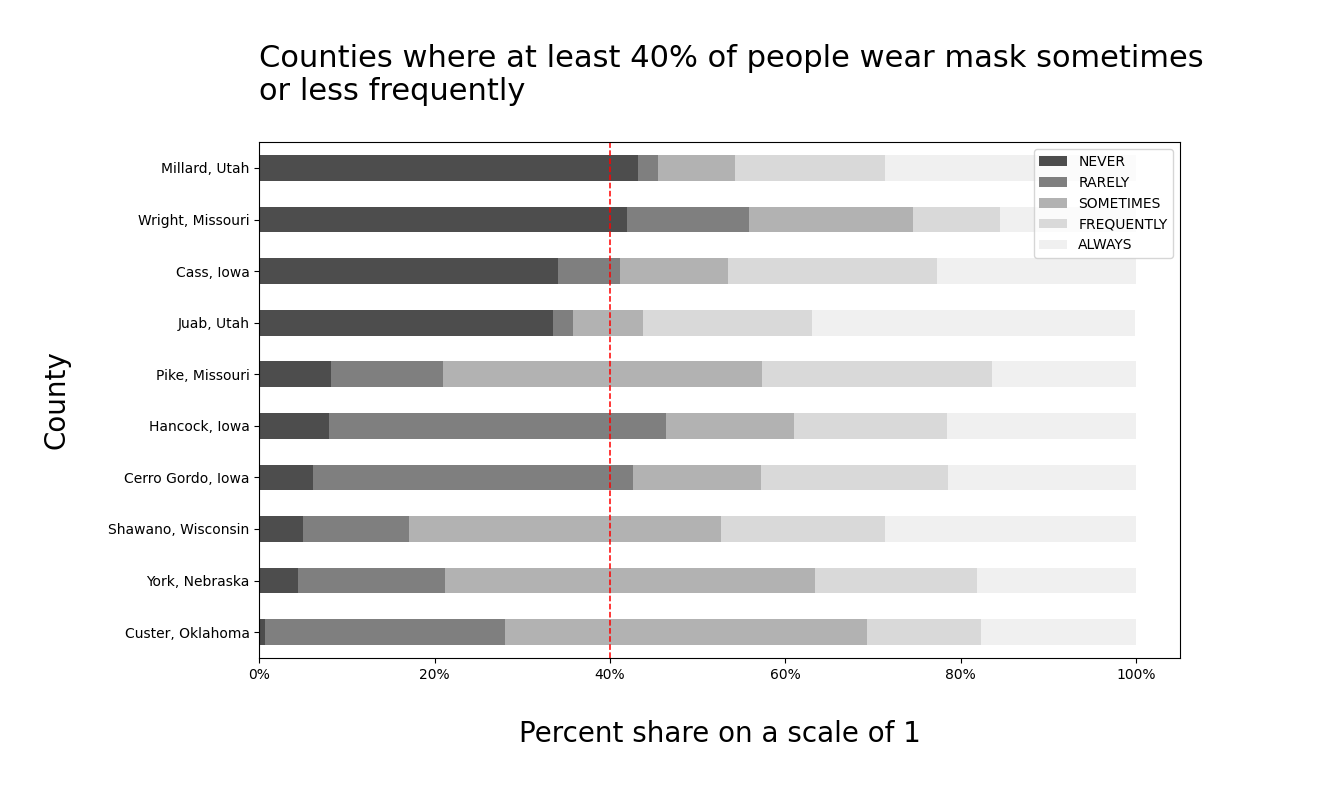

In [36]:
# the df_mapped only returns the values corresponding to the counties lists above
over33_all_cties_df = pd.DataFrame(over33_all_cties, columns=["COUNTY", "STATE"])

# Filter df_mapped to include only rows matching the COUNTY and STATE pairs in over33_all_cties
df_over33_cties = df_mapped.merge(over33_all_cties_df, on=["COUNTY", "STATE"], how="inner")

# Create a new column combining COUNTY and STATE for the x-tick labels
df_over33_cties["County_State"] = df_over33_cties["COUNTY"] + ", " + df_over33_cties["STATE"]

# Select columns to plot
columns_to_plot = ["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]

# Define grayscale colors for each frequency
colors = ["#4D4D4D", "#7F7F7F", "#B2B2B2", "#D9D9D9", "#F0F0F0"]

# Sort the DataFrame by the "NEVER" column in descending order
df_sorted = df_over33_cties.set_index("County_State").sort_values(by="NEVER")

# Plot the sorted DataFrame
df_sorted[columns_to_plot].plot(kind="barh", stacked=True, figsize=(12, 8), color=colors)

# Customize plot
plt.ylabel("\nCounty\n", fontsize=20)
plt.xlabel("\nPercent share on a scale of 1\n", fontsize=20)
plt.title("\nCounties where at least 40% of people wear mask sometimes             \nor less frequently\n", fontsize=22, loc="left")
#plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Add a vertical line at x=0.4 with a red color
plt.axvline(x=0.4, color="red", linestyle="--", linewidth=1.1)

# Add a blue dashed line at y=0.12
#plt.axvline(x=0.12, color="#B2B2B2", linestyle="--", linewidth=1.5)

# Add a tick label for the blue line at y=0.12
#plt.text(0.02, -1.5, 'SOMETIMES\naverage (0.12)', color="black", fontsize=12, rotation=45, va='center')

# Modify x-tick labels to show percentages
xticks = plt.gca().get_xticks()  # Get current x-tick positions
plt.gca().set_xticklabels([f"{int(x * 100)}%" for x in xticks])  # Format each x-tick

plt.tight_layout()

plt.show()

NOTE:  

It is important to repeat that the graph is from a list of States that all have counties with "riskier" frequencies values of over or equal to 33%. These bars are representing these "riskier" counties.     
We **find here** some of the **outliers** that we noticed in the box plot.

We understand from the graph above that from these 10 counties: 
- **two are clearly with over 40% of people who NEVER** wear mask : 
  - **Millard**, Utah
  - **Wright**, Missouri
- **two others are close** but still with a very big majority of NEVER:
  - **Juab**, Utah
  - **Cass**, Iowa

Then we have **two counties** where a big majority of people **RARELY** wear mask:
- **Hancock**, Iowa
- **Cerro Gordo**, Iowa
- **Custer**, Oklahoma (to a lesser extent)

From these first 7, three are from the state of Iowa and 2 from Utah.

The three ones left still have a majority of people who SOMETIMES wear mask:
- Shawano, Wisconsin
- York, Nebraska
- Pike, Missouri

# Recommendations

Because the **NEVER portion** of these 3 following counties are **all bigger than their respective ALWAYS**, we recommend to really **take the necessary precautions** **when indoor and when near people** while interacting in these counties: 
- **Millard**, UTAH
- **Wright**, MISSOURI
- **Cass**, UTAH  
- To a lesser extent, but still concerning, the county of **Juab**, UTAH. 

We also recommend to **stay cautious** in these 3 counties, where the portion of **RARELY is bigger or equal to BOTH portions of FREQUENTLY and ALWAYS**: 
- **Hancock**, IOWA
- **Cerro Gordo**, IOWA
- **Custer**, OKLAHOMA

# Why?

Why these UTAH, IOWA states and also Custer OKLAHOMA and Wright MISSOURI have so low shares in FREQUENTLY and ALWAYS frequency? 

A search online indicated that the reason could be the absence of a statewide mask mandate when the survey took place, 11/07/2020. 

Here is a simple table: 

In [37]:
# Define the data as a dictionary
data_maskmandate = {
    "County": ["Millard", "Wright", "Cass", "Juab", "Hancock", "Cerro Gordo", "Custer"],
    "State": ["Utah", "Missouri", "Utah", "Utah", "Iowa", "Iowa", "Oklahoma"],
    "Mask Mandate (as of July 7, 2020)": [False, False, False, False, False, False, False],
    "New Mask Mandate Date": ["November 9, 2020", "N/A", "November 9, 2020", "November 9, 2020", "November 17, 2020", "November 17, 2020", "N/A"]
}

# Convert to DataFrame
df_maskmandates = pd.DataFrame(data_maskmandate)

df_maskmandates

,County,State,"Mask Mandate (as of July 7, 2020)",New Mask Mandate Date
0,Millard,Utah,False,"November 9, 2020"
1,Wright,Missouri,False,N/A
2,Cass,Utah,False,"November 9, 2020"
3,Juab,Utah,False,"November 9, 2020"
4,Hancock,Iowa,False,"November 17, 2020"
5,Cerro Gordo,Iowa,False,"November 17, 2020"
6,Custer,Oklahoma,False,N/A


UTAH and IOWA **did NOT have** a mask mandate **at the date of the survey**, it was implemented only months after, in November. 

**For Iowa:**  

The state government in Iowa did not implement a statewide mask mandate in July 2020. In fact, on July 7, 2020, Governor Kim Reynolds indicated that "local governments cannot implement mask requirements because they are not consistent with her public health disaster proclamation".  

**This stance from the state leadership likely contributed to some residents choosing not to wear masks**.   

- Source: [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Iowa)

**For Utah:**  

The search results do not provide specific information about Utah's mask policies in July 2020. However, we do know that Utah eventually implemented a statewide mask mandate, which ended on April 10, 2021.
It's worth noting that throughout the pandemic, mask policies varied widely between states, with some implementing strict mandates and others leaving it up to individual choice or local jurisdictions. The debate around mask-wearing was often politically charged and contentious in many parts of the country.

For Missouri and Oklahoma: 
No formal mandates were implemented, only formal recommendations. 
- Sources: [leadinggage](https://leadingage.org/state-state-face-mask-mandates/)


Sources used for the table: 
- [deseret](https://www.deseret.com/utah/2021/3/24/22349287/utah-gov-cox-signs-bill-lifting-statewide-mask-mandate-april-10-endgame-2021-covid-19-restrictions/)
- [hushblackwell](https://www.huschblackwell.com/utah-state-by-state-covid-19-guidance)
- [usnews](https://www.usnews.com/news/best-states/articles/these-are-the-states-with-mask-mandates)
- [stltriallawyers](https://stltriallawyers.com/missouri-mask-mandates/)
- [themissouritimes](https://themissouritimes.com/where-are-masks-required-in-missouri/)
- [missouriindependent](https://missouriindependent.com/2021/12/01/missouri-health-department-found-mask-mandates-work-but-didnt-make-findings-public/)


---

# What's Next?

For us to better understand we need more granular data. Data about: 
- the **number of people surveyed per county** and per state,
- their **age**
- their **gender**
- their **work**
This data will give us **more angles to explore** and potentially observe new patterns or behaviors. 

A **survey post mask-mandate** would also enable us to **extract differences and persistence** in the prior observed behaviors and frequencies. 

Data from the **original study** is also paired with this data here, and studying it could also offer more insightful understanding of the consequences of these different frequencies of wearing mask. 